# Математические Основы Data Science и EDA

## 2 Часть

Задание: В папке присутствует файл ab_test_ensembles.csv, который содержит реальные данные ab теста. Необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус). Условия гипотез теже.
В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.<br>
Ответьте на 2 вопроса:<br>
* Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
* Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

## Дизайн эксперимента

Сформулируем наши гипотезы.
Посколько мы заранее не имеем представления о том, будет ли новый дизайн сайта работать лучше или хуже, чем текущий вариант, мы выбираем двусторонний статистический тест Two-Tailed Test <br>

Нулевая гипотеза:<br>
* H0 : p = p0 <br>

Альтернативная: <br>
* H : p != p0 <br>

где p и p0 означают коэффициенты конверсии между новым и старым вариантами соответственно. Так же необходимо выбрать уровень доверия (confidence level). В нашем случае мы решили что это будет 95%. Имея уровень доверия в 95% необходимо рассчитать показатель альфа, который будет равен (1 - 0.95) для нашего теста = 0.05.


Для проведения A/B тестирования нам необходимо 2 группы испытемых:
1. Контрольная (Control) группа - та группа пользователей, которым будет показываться старая версия сайта.
2. Эксперементальная (Treatment) группа - та группа пользователей, которым будет показываться новая версия сайта.

Нашей целевой переменной (Dependant Variable) будет выступать - уровень конверсии (conversion_rate). Целевая переменная представленна бинарно:
* 0 - пользователь не купил ничего в течение своей сессии на сайте
* 1 - пользователь купил продукт в течение своей сессии на сайте

In [17]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Настройки отображения графиков
%matplotlib inline
# Стили графиков -> https://seaborn.pydata.org/generated/seaborn.set_style.html
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

# Определение размера контрольной и испытуемой выборок

In [4]:
# Считаем размер эффекта -> https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_effectsize.html
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки -> https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.html?highlight=normalindpower
# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


Как увидим далее, данный объем выборки с 200K+ записей соответствуют этому критерию.

In [6]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [10]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


# 2.1 Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_2?

При такой постановке вопроса AB-тестирования:<br>
*    вариант А (control) - variants = 'standard'
*    варинат B (treatment) - variants = 'svm_ensemble_v_1_22'

По условию задачи не отбираем случайные подвыборки, а рассматриваем весь набор значений

In [7]:
pd.crosstab(df['variants'], df['converted'])

converted,0,1
variants,,
standard,129500,17739
svm_ensemble_v_1_22,129741,17498


In [13]:
conversion_rates = df.groupby('variants')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
variants,,,
standard,0.120478,0.325519,0.000848
svm_ensemble_v_1_22,0.118841,0.323601,0.000843


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя примерно одинаково, выборочное среднее коэффициента конверсии равно ~12.0% в обоих случаях

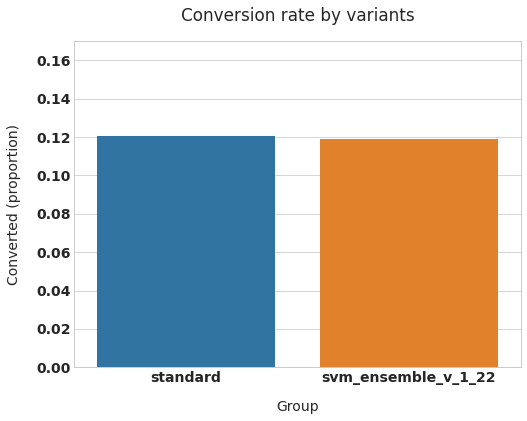

In [21]:
plt.figure(figsize=(8,6));
sns.barplot(x=df['variants'], y=df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by variants', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [19]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['variants'] == 'standard']['converted']
treatment_results = df[df['variants'] == 'svm_ensemble_v_1_22']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.37
p-value: 0.171
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.120]


Так как p-значение = 0.171 что является высоким показателем по сравнению с 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и разница в уровне конверсии - это случайность.
<br>
Доверительный интервал для испытуемой группы [0.117, 0.120] или 11,7% и 12,0% соответственно:
*    Он включает наш baseline
*    Он не достигает нашей цели 15%
*    Более того, по сравнению с контрольной группой (базовый вариант А) конверсия стала только хуже.

Итого: переходить на вариант "svm_ensemble_v_1_22" в целях повышения конверсии не следует. Если текущий вариант не устраивает, надо усовершенствовать что-то еще, вложив ресурсы (время, деньги), чтобы его повысить.

## 2.2 Стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы?

При такой постановке вопроса AB-тестирования варианты те же:
    вариант А (control) - variants = 'standard'
    варинат B (treatment) - variants = 'svm_ensemble_v_1_22'
Однако необходимо разбить массив данных на два подмассива по признаку user_type = registered_user | new_user

In [25]:
df_old_users = df.loc[df['user_type']=='registered_user']
df_new_users = df.loc[df['user_type']=='new_user']

In [26]:
pd.crosstab(df_old_users['variants'], df_old_users['converted'])

converted,0,1
variants,,
standard,64638,8804
svm_ensemble_v_1_22,64909,8889


In [27]:
pd.crosstab(df_new_users['variants'], df_new_users['converted'])

converted,0,1
variants,,
standard,64862,8935
svm_ensemble_v_1_22,64832,8609


In [28]:
conversion_rates_old = df_old_users.groupby('variants')['converted'].agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_new = df_new_users.groupby('variants')['converted'].agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})

In [29]:
conversion_rates_old

,CR mean,CR std,CR se
variants,,,
standard,0.119877,0.324818,0.001199
svm_ensemble_v_1_22,0.120450,0.325488,0.001198


In [30]:
conversion_rates_new

,CR mean,CR std,CR se
variants,,,
standard,0.121075,0.326215,0.001201
svm_ensemble_v_1_22,0.117223,0.321686,0.001187


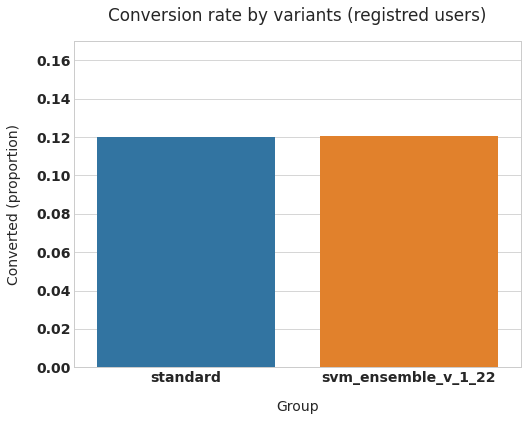

In [31]:
plt.figure(figsize=(8,6));
sns.barplot(x=df_old_users['variants'], y=df_old_users['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by variants (registred users)', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

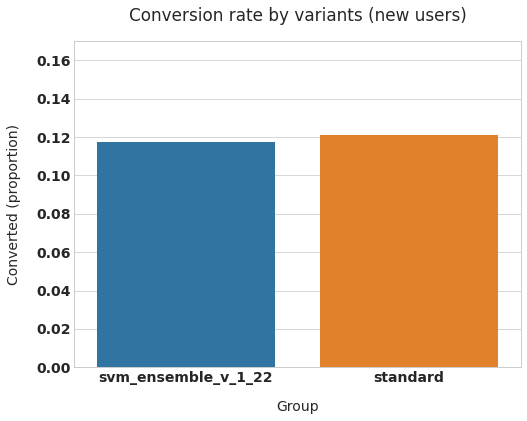

In [32]:
plt.figure(figsize=(8,6));
sns.barplot(x=df_new_users['variants'], y=df_new_users['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by variants (new users)', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

Как видим, улучшение конверсии не наблюдается ни для старых зарегистрированных клиентов, ни для новых. Для новых клиентов конверсия даже в целом несколько снижается с вариантом 'svm_ensemble_v_1_22'. Но перед формированием окончательного вывода посчитаем статистики и доверительные интервалы.

In [33]:
# Старые (зарегистрированные) пользователи
control_results = df_old_users[df['variants'] == 'standard']['converted']
treatment_results = df_old_users[df['variants'] == 'svm_ensemble_v_1_22']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print('** Registered users **')
print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

** Registered users **
Z-statistic: -0.34
p-value: 0.735
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


Вывод: p-значение = 0.735 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0.
Доверительный интервал для испытуемой группы [0.118, 0.123] или 11,8% и 12,3% соответственно:

    Включает baseline
    Не достигает цели конверсии 15%

Итого: переходить старых пользователей на вариант "svm_ensemble_v_1_22" в целях повышения конверсии не следует.
Если текущий вариант не устраивает, надо усовершенствовать что-то еще, вложив ресурсы (время, деньги), чтобы его повысить.

In [34]:
# Новые пользователи
control_results = df_new_users[df['variants'] == 'standard']['converted']
treatment_results = df_new_users[df['variants'] == 'svm_ensemble_v_1_22']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print('** New users **')
print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

** New users **
Z-statistic: 2.28
p-value: 0.023
CI 95% for control group: [0.119, 0.123]
CI 95% for treatment group: [0.115, 0.120]


Вывод: p-значение = 0.023 менее выбранного 0.05, следовательно есть основание отклонить нулевую гипотезу H0.<br>
*НО!* Доверительный интервал для испытуемой группы [0.115, 0.120] показывает, что для варианта "svm_ensemble_v_1_22" конверсия получилась меньше, чем базового стандартного варианта (статистически значимо ниже).<br>
Таким образом, переводить новых пользователей на вариант "svm_ensemble_v_1_22" в целях повышения конверсии также не следует. Если текущий вариант не устраивает, надо усовершенствовать что-то еще, вложив ресурсы (время, деньги), чтобы его повысить.